# QFIE For Lighting Controller System
This notebook aims to illustrate how QFIE can control efficiently a lighting system, in  which  the  control system dim the bulb light automatically according to the environmental Light. Two input variables are considered, namely the environment light and the  changing  rate of the environmental light. Finally, the control surface of the system will be obtained both using QFIE and the canonical Mamdani fuzzy system, which configuration is reported in the paper.  

Firstly, let us import the required libraries.

In [1]:
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import QFIE.FuzzyEngines as FE

The system is a MISO composed of two input variables and one output variable. In detail:

Inputs:

- Environment Light (env_light): three linguistic terms are considered: 'Dark', 'Medium', 'Light'

- Changing Rate (change_rate): three lingiuistic terms are considered: 'Negative Small', 'Zero', 'Positive Small'

Output:

- Dimmer Control (dimmer_ctrl): four linguistic terms are considered: 'Very Small', 'Small', 'Big', 'Very Big'

    
By running the following cell, the fuzzy sets used are graphically shown. 

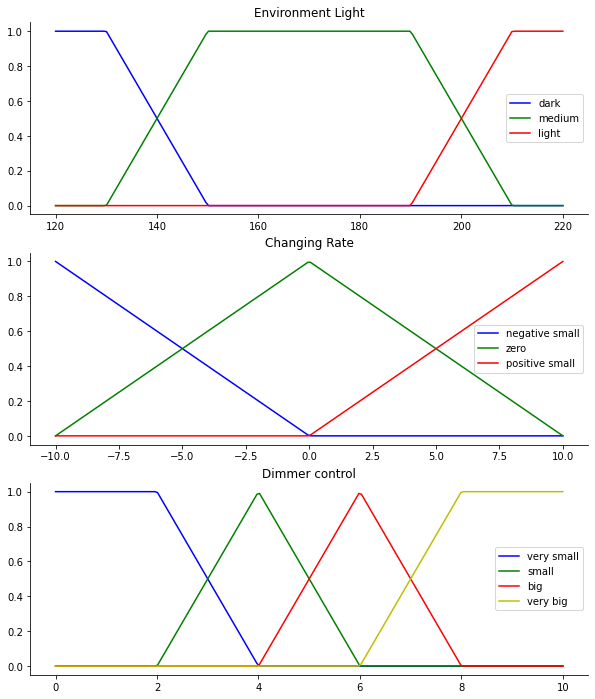

In [2]:
env_light = np.linspace(120, 220, 200)
changing_rate = np.linspace(-10, 10, 200)
dimmer_control = np.linspace(0, 10, 200)



l_dark = fuzz.trapmf(env_light, [120,120,130,150])
l_medium = fuzz.trapmf(env_light, [130,  150, 190,210])
l_light = fuzz.trapmf(env_light, [190,  210, 220, 220])

r_ns = fuzz.trimf(changing_rate, [-10,-10,0])
r_zero = fuzz.trimf(changing_rate, [-10,0,10])
r_ps = fuzz.trimf(changing_rate, [0,10,10])

dm_vs = fuzz.trapmf(dimmer_control, [0,0,2,4])
dm_s = fuzz.trimf(dimmer_control, [2,4,6])
dm_b = fuzz.trimf(dimmer_control, [4,6,8])
dm_vb = fuzz.trapmf(dimmer_control, [6,8,10,10])




# Visualize these universes and membership functions
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(10, 12))


ax0.plot(env_light, l_dark, 'b', linewidth=1.5, label='dark')
ax0.plot(env_light, l_medium, 'g', linewidth=1.5, label='medium')
ax0.plot(env_light, l_light, 'r', linewidth=1.5, label='light')
ax0.set_title('Environment Light')
ax0.legend()

ax1.plot(changing_rate, r_ns, 'b', linewidth=1.5, label='negative small')
ax1.plot(changing_rate, r_zero, 'g', linewidth=1.5, label='zero')
ax1.plot(changing_rate, r_ps, 'r', linewidth=1.5, label='positive small')
ax1.set_title('Changing Rate')
ax1.legend()


ax2.plot(dimmer_control, dm_vs, 'b', linewidth=1.5, label='very small')
ax2.plot(dimmer_control, dm_s, 'g', linewidth=1.5, label='small')
ax2.plot(dimmer_control, dm_b, 'r', linewidth=1.5, label='big')
ax2.plot(dimmer_control, dm_vb, 'y', linewidth=1.5, label='very big')
ax2.set_title('Dimmer control')
ax2.legend()

# Turn off top/right axes
for ax in (ax0, ax1, ax2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()


plt.show()

The rules base of the system is composed of the following rules: 

- if env_light is dark and change_rate is pos_small then dimmer_ctrl is big
- if env_light is dark and change_rate is zero then dimmer_ctrl is big
- if env_light is dark and change_rate is neg_small then dimmer_ctrl is very_big
- if env_light is medium and change_rate is pos_small then dimmer_ctrl is small
- if env_light is medium and change_rate is zero then dimmer_ctrl is big
- if env_light is medium and change_rate is neg_small then dimmer_ctrl is big
- if env_light is light and change_rate is pos_small then dimmer_ctrl is very_small
- if env_light is light and change_rate is zero then dimmer_ctrl is small
- if env_light is light and change_rate is neg_small then dimmer_ctrl is big

By running the following two cells QFIE is properly initialized



In [3]:
rules = ['if env_light is dark and change_rate is pos_small then dimmer_ctrl is big',
         'if env_light is dark and change_rate is zero then dimmer_ctrl is big',
         'if env_light is dark and change_rate is neg_small then dimmer_ctrl is very_big',
         'if env_light is medium and change_rate is pos_small then dimmer_ctrl is small',
         'if env_light is medium and change_rate is zero then dimmer_ctrl is big',
         'if env_light is medium and change_rate is neg_small then dimmer_ctrl is big',
         'if env_light is light and change_rate is pos_small then dimmer_ctrl is very_small',
         'if env_light is light and change_rate is zero then dimmer_ctrl is small',
         'if env_light is light and change_rate is neg_small then dimmer_ctrl is big']

In [4]:
qfie = FE.QuantumFuzzyEngine(verbose=False)
qfie.input_variable(name='env_light', range=env_light)
qfie.input_variable(name='change_rate', range=changing_rate)
qfie.output_variable(name='dimmer_ctrl', range=dimmer_control)

qfie.add_input_fuzzysets(var_name='env_light', set_names=['dark', 'medium', 'light'], sets=[l_dark, l_medium, l_light])
qfie.add_input_fuzzysets(var_name='change_rate', set_names=['neg_small', 'zero', 'pos_small'], sets=[r_ns, r_zero, r_ps])
qfie.add_output_fuzzysets(var_name='dimmer_ctrl', set_names=['very_small', 'small', 'big', 'very_big'],sets=[dm_vs, dm_s, dm_b, dm_vb])
qfie.set_rules(rules)



To obtain the control surface of QFIE, it is used to fire the rules in 121 different input combinations. In detail, for 11 values of env_light 11 different values of change_rate are considered. The 121 outputs obtained are collected in a list which will be used at the end of the notebook to plot the control surface. 

In [5]:
el_list, cr_list = [t for t in range(120, 230, 10)], [s for s in range(-10, 12, 2)]
f_quantum = []
for el in el_list:
    for cr in cr_list:
        qfie.build_inference_qc({'env_light':el, 'change_rate':cr}, draw_qc=False)
        f_quantum.append(qfie.execute(n_shots=1000, plot_histo=False)[0])

___

Then, the classical Mamdani system is implemented by using the python library Sci-kit Fuzzy. The following cells initializes the system as required from the library

In [6]:
from skfuzzy import control as ctrl

In [7]:
env_l = ctrl.Antecedent(env_light, 'env_light')
cng_r = ctrl.Antecedent(changing_rate , 'change_rate')
dim = ctrl.Consequent(dimmer_control, 'dimmer_ctrl')

env_l['dark'] = l_dark
env_l['medium'] = l_medium
env_l['light'] = l_light 

cng_r['neg_small'] = r_ns
cng_r['zero'] = r_zero
cng_r['pos_small'] = r_ps 

dim['very_small'] = dm_vs
dim['small'] = dm_s
dim['big'] = dm_b
dim['very_big'] = dm_vb


rule1 = ctrl.Rule(env_l['dark'] & cng_r['pos_small'], dim['big'])
rule2 = ctrl.Rule(env_l['dark'] & cng_r['zero'], dim['big'])
rule3 = ctrl.Rule(env_l['dark'] & cng_r['neg_small'], dim['very_big'])
rule4 = ctrl.Rule(env_l['medium'] & cng_r['pos_small'], dim['small'])
rule5 = ctrl.Rule(env_l['medium'] & cng_r['zero'], dim['big'])
rule6 = ctrl.Rule(env_l['medium'] & cng_r['neg_small'], dim['big'])
rule7 = ctrl.Rule(env_l['light'] & cng_r['pos_small'], dim['very_small'])
rule8 = ctrl.Rule(env_l['light'] & cng_r['zero'], dim['small'])
rule9 = ctrl.Rule(env_l['light'] & cng_r['neg_small'], dim['big'])

dim_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9])
dim_sys = ctrl.ControlSystemSimulation(dim_ctrl)

By running the following cell, the same combinations of inputs are passed to the classical control which computes the 121 output. All the output values are stored in a list.

In [8]:
f_classical = []
for el in el_list:
    for cr in cr_list:
        dim_sys.input['env_light']=el    
        dim_sys.input['change_rate']=cr

        dim_sys.compute()
        f_classical.append(dim_sys.output['dimmer_ctrl'])

At this point, both the QFIE and Classical system' control surfaces can be plotted. Firstly, the following cell shows the former surface. 

Text(0.5, 0, 'Dimmer Control')

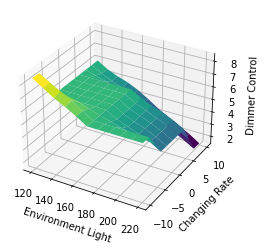

In [9]:
from mpl_toolkits.mplot3d import Axes3D

X, Y, = el_list, cr_list
plotx,ploty, = np.meshgrid(np.linspace(np.min(X),np.max(X),11), np.linspace(np.min(Y),np.max(Y),11))
Z = np.zeros_like(plotx)
counter = 0 
for i in range(len(el_list)):
    for j in range(len(cr_list)):
        Z[i,j]=f_quantum[counter]
        counter+=1
        
zfig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(plotx, ploty, Z, rstride=1, cstride=1, cmap='viridis',
                       linewidth=0.4, antialiased=True)
ax.set_xlabel('Environment Light')
ax.set_ylabel('Changing Rate')
ax.set_zlabel('Dimmer Control')

Then, the classical surface is displayed by running the following cell. 

Text(0.5, 0, 'Dimmer Control')

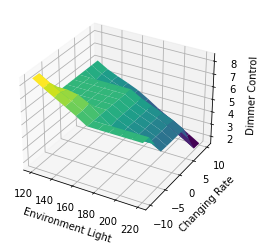

In [10]:
X, Y, = el_list, cr_list
plotx,ploty, = np.meshgrid(np.linspace(np.min(X),np.max(X),11), np.linspace(np.min(Y),np.max(Y),11))
Z = np.zeros_like(plotx)
counter = 0 
for i in range(len(el_list)):
    for j in range(len(cr_list)):
        Z[i,j]=f_classical[counter]
        counter+=1
        
zfig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(plotx, ploty, Z, rstride=1, cstride=1, cmap='viridis',
                       linewidth=0.4, antialiased=True)
ax.set_xlabel('Environment Light')
ax.set_ylabel('Changing Rate')
ax.set_zlabel('Dimmer Control')

The two surfaces show how QFIE is able to control in a very similar way to a classical Mamdani fuzzy control the lighting control system, despite the computational advantage in firing the fuzzy rules in a parallel way.